# Forecast Performance Monitoring and Concept Drift Detection

This notebook monitored forecast performance over time
and detected potential concept drift using forecast errors.

The goal was to identify regime changes early
and signal when retraining would be required.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")
pd.set_option("display.max_columns", 50)


## Loading Forecasts and Actual Demand

Forecast outputs were joined with actual demand
to compute errors for monitoring.


In [2]:
# Loaded reconciled forecasts
forecast_df = pd.read_csv("../outputs/forecasts/reconciled_forecasts.csv")
forecast_df["date"] = pd.to_datetime(forecast_df["date"])

# Loaded actual demand from feature-engineered dataset
actuals = pd.read_csv("../data/processed/feature_engineered_data.csv")
actuals["date"] = pd.to_datetime(actuals["date"])

# Kept only required columns
actuals = actuals[["date", "sku_store", "demand"]]

forecast_df.head(), actuals.head()


(        date             sku_store  p10  p50       p90          item_id  \
 0 2012-02-05      FOODS_3_062_TX_2  0.0  0.0  3.643086      FOODS_3_062   
 1 2012-02-05      FOODS_3_123_TX_2  0.0  0.0  0.982428      FOODS_3_123   
 2 2012-02-05    HOBBIES_1_409_TX_3  0.0  0.0  1.903983    HOBBIES_1_409   
 3 2012-02-05  HOUSEHOLD_1_021_TX_3  0.0  0.0  3.791410  HOUSEHOLD_1_021   
 4 2012-02-05      FOODS_2_311_TX_3  0.0  0.0  5.011357      FOODS_2_311   
 
   store_id state_id     cat_id  p10_total  p50_total   p90_total  \
 0     TX_2       TX      FOODS        0.0        0.0  326.707637   
 1     TX_2       TX      FOODS        0.0        0.0  326.707637   
 2     TX_3       TX    HOBBIES        0.0        0.0  326.707637   
 3     TX_3       TX  HOUSEHOLD        0.0        0.0  326.707637   
 4     TX_3       TX      FOODS        0.0        0.0  326.707637   
 
    p10_reconciled  p50_reconciled  p90_reconciled  
 0             NaN             NaN        3.643086  
 1             NaN  

## Merging Forecasts with Actual Demand

Forecasts and actual demand were aligned
at the SKU–date level for error computation.


In [3]:
monitor_df = forecast_df.merge(
    actuals,
    on=["date", "sku_store"],
    how="inner"
)

monitor_df.head()


,date,sku_store,p10,p50,p90,item_id,store_id,state_id,cat_id,p10_total,p50_total,p90_total,p10_reconciled,p50_reconciled,p90_reconciled,demand
0,2012-02-05,FOODS_3_062_TX_2,0.0,0.0,3.643086,FOODS_3_062,TX_2,TX,FOODS,0.0,0.0,326.707637,NaN,NaN,3.643086,0
1,2012-02-05,FOODS_3_123_TX_2,0.0,0.0,0.982428,FOODS_3_123,TX_2,TX,FOODS,0.0,0.0,326.707637,NaN,NaN,0.982428,0
2,2012-02-05,HOBBIES_1_409_TX_3,0.0,0.0,1.903983,HOBBIES_1_409,TX_3,TX,HOBBIES,0.0,0.0,326.707637,NaN,NaN,1.903983,1
3,2012-02-05,HOUSEHOLD_1_021_TX_3,0.0,0.0,3.791410,HOUSEHOLD_1_021,TX_3,TX,HOUSEHOLD,0.0,0.0,326.707637,NaN,NaN,3.791410,1
4,2012-02-05,FOODS_2_311_TX_3,0.0,0.0,5.011357,FOODS_2_311,TX_3,TX,FOODS,0.0,0.0,326.707637,NaN,NaN,5.011357,5


## Computing Forecast Errors

Errors were computed using the median (P50) forecast,
which represented expected demand.


In [4]:
monitor_df["absolute_error"] = (
    monitor_df["demand"] - monitor_df["p50_reconciled"]
).abs()


## Rolling Error Statistics

Rolling error metrics were used to smooth noise
and highlight sustained performance degradation.


In [5]:
window = 14

monitor_df["rolling_error_mean"] = (
    monitor_df
    .groupby("sku_store")["absolute_error"]
    .rolling(window)
    .mean()
    .reset_index(level=0, drop=True)
)

monitor_df["rolling_error_std"] = (
    monitor_df
    .groupby("sku_store")["absolute_error"]
    .rolling(window)
    .std()
    .reset_index(level=0, drop=True)
)


## Drift Detection Rule

Concept drift was flagged when rolling error
exceeded a dynamic threshold based on historical variability.


In [6]:
threshold_multiplier = 2

monitor_df["drift_flag"] = (
    monitor_df["absolute_error"]
    > monitor_df["rolling_error_mean"]
    + threshold_multiplier * monitor_df["rolling_error_std"]
).astype(int)


## Drift Visualization

Error trends and drift signals were visualized
for a representative SKU.


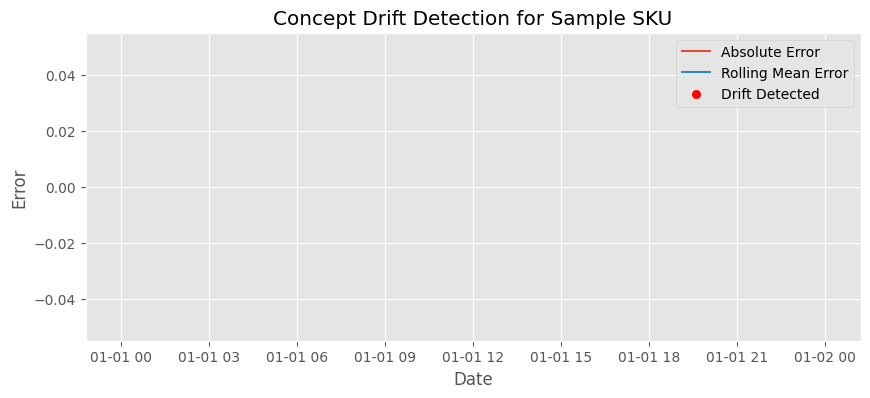

In [7]:
sample_sku = monitor_df["sku_store"].iloc[0]
subset = monitor_df[monitor_df["sku_store"] == sample_sku]

plt.figure(figsize=(10, 4))
plt.plot(subset["date"], subset["absolute_error"], label="Absolute Error")
plt.plot(subset["date"], subset["rolling_error_mean"], label="Rolling Mean Error")
plt.scatter(
    subset[subset["drift_flag"] == 1]["date"],
    subset[subset["drift_flag"] == 1]["absolute_error"],
    color="red",
    label="Drift Detected"
)

plt.legend()
plt.title("Concept Drift Detection for Sample SKU")
plt.xlabel("Date")
plt.ylabel("Error")
plt.show()


## Aggregating Drift Signals

Drift signals were aggregated across SKUs
to assess system-wide stability.


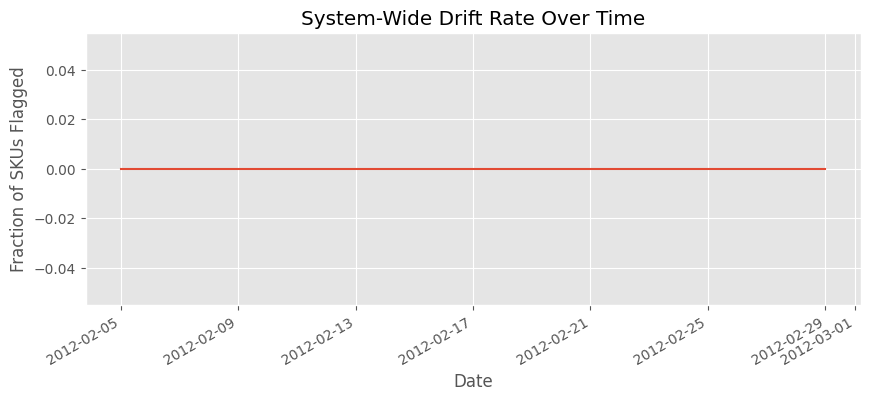

In [8]:
daily_drift_rate = (
    monitor_df
    .groupby("date")["drift_flag"]
    .mean()
)

plt.figure(figsize=(10, 4))
daily_drift_rate.plot()
plt.title("System-Wide Drift Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Fraction of SKUs Flagged")
plt.show()


## Saving Monitoring Outputs

Drift signals were saved for alerting
and retraining decision workflows.


In [9]:
import os

os.makedirs("../outputs/monitoring", exist_ok=True)

monitor_df.to_csv(
    "../outputs/monitoring/drift_monitoring.csv",
    index=False
)


## Summary

In this notebook:

- Forecast errors were computed at SKU level
- Rolling statistics captured performance trends
- A rule-based approach detected concept drift
- Drift behavior was visualized and aggregated
- Monitoring outputs were saved for production use

This completed the end-to-end demand forecasting system.
